# Redes Neuronales Recurrentes - Clasificación de Audio

Empezaremos trabajando con el conjunto de datos de audio '16000_pcm_speeches', el cual contiene subcarpetas para cada orador. Este ejercicio se centrará en la clasificación de audio utilizando Redes Neuronales Recurrentes.

Estos son los pasos generales que seguiremos:

Preprocesamiento de datos: Cargar y procesar los archivos de audio, ajustarlos a la misma longitud si es necesario.
Preparación de los datos: Dividir los datos en conjuntos de entrenamiento y prueba, convertir las etiquetas en una forma que pueda ser utilizada por la red neuronal.
Construcción del modelo: Crear la arquitectura de la Red Neuronal Recurrente utilizando Keras o una biblioteca similar.
Entrenamiento del modelo: Entrenar el modelo en el conjunto de datos de entrenamiento, observar la precisión y la pérdida durante el entrenamiento.
Evaluación del modelo: Probar el modelo en el conjunto de datos de prueba para evaluar su rendimiento.
Interpretación de los resultados: Analizar los resultados y determinar cómo se podría mejorar el modelo o el preprocesamiento de los datos.

In [1]:
# Importar librerías

import os
import librosa
import numpy as np

In [2]:
# directorio de datos
DATA_DIR = '16000_pcm_speeches'

# lista para guardar los datos de audio y las etiquetas
audio_data = []
labels = []

# recorrer todas las subcarpetas dentro de la carpeta de datos
for speaker in os.listdir(DATA_DIR):
    speaker_dir = os.path.join(DATA_DIR, speaker)

    # asegúrate de que es un directorio
    if os.path.isdir(speaker_dir):

        # recorrer todos los archivos de audio en la carpeta
        for file_name in os.listdir(speaker_dir):
            # cargar el archivo de audio
            file_path = os.path.join(speaker_dir, file_name)
            audio, sr = librosa.load(file_path)

            # ajustar la longitud del audio a 1 segundo (16000 muestras)
            if len(audio) < sr:
                audio = np.pad(audio, (0, sr - len(audio)))
            elif len(audio) > sr:
                audio = audio[:sr]

            # guardar el audio y la etiqueta
            audio_data.append(audio)
            labels.append(speaker)

# convertir a numpy arrays
audio_data = np.array(audio_data)
labels = np.array(labels)

Este código recorre todas las subcarpetas en el directorio de datos, que se asume que son los nombres de los oradores. Carga cada archivo de audio y ajusta la longitud del audio a exactamente 1 segundo (o 16000 muestras, que es la frecuencia de muestreo de los audios). Los datos de audio y las etiquetas se guardan en listas, que luego se convierten en arrays de numpy.

En este paso, dividiremos nuestros datos en un conjunto de entrenamiento y un conjunto de prueba. Además, codificaremos nuestras etiquetas de texto (los nombres de los oradores) en un formato que la red neuronal pueda entender.

In [3]:
# Preparación de los datos

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# codificar las etiquetas de texto a números
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# convertir las etiquetas a codificación one-hot
labels_onehot = to_categorical(labels_encoded)

# dividir los datos en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(audio_data, labels_onehot, test_size=0.2, random_state=42)


2023-06-10 21:15:29.555697: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


En este código, utilizamos la clase LabelEncoder de scikit-learn para convertir las etiquetas de texto a números, y luego convertimos estos números a una representación "one-hot" utilizando la función to_categorical de Keras. La representación one-hot es una matriz donde todos los elementos son 0, excepto uno que es 1, y se utiliza comúnmente para representar variables categóricas en machine learning.

Después, utilizamos la función train_test_split de scikit-learn para dividir los datos en un conjunto de entrenamiento (80% de los datos) y un conjunto de prueba (20% de los datos).

Para clasificar los audios, vamos a utilizar una Red Neuronal Recurrente (RNN). Las RNN son especialmente adecuadas para datos secuenciales como el audio. En este caso, vamos a utilizar una variante de RNN llamada Long Short-Term Memory (LSTM), que es capaz de aprender dependencias a largo plazo en los datos.

In [4]:
# Construcción del modelo

from keras.models import Sequential
from keras.layers import LSTM, Dense

# construir el modelo
model = Sequential()
model.add(LSTM(128, input_shape=(sr, 1)))
model.add(Dense(len(np.unique(labels)), activation='softmax'))

# compilar el modelo
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# imprimir un resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 67,463
Trainable params: 67,463
Non-trainable params: 0
_________________________________________________________________


Este código construye un modelo secuencial en Keras, que es un tipo de modelo que se compone de una pila de capas. La primera capa es una capa LSTM con 128 unidades. La forma de entrada de esta capa es (sr, 1), donde sr es la frecuencia de muestreo de los audios (16000 en este caso). La última capa es una capa densa con tantas unidades como oradores únicos hay en los datos, y utiliza la activación softmax, que es común para problemas de clasificación multiclase.

Después de construir el modelo, lo compilamos con la función de pérdida de entropía cruzada categórica (que es utilizada para problemas de clasificación multiclase), el optimizador Adam, y pedimos que se registre la precisión durante el entrenamiento.

El entrenamiento de un modelo de machine learning implica alimentarlo con datos y dejar que ajuste sus parámetros para minimizar su error de predicción. En este caso, vamos a entrenar nuestro modelo con los datos de entrenamiento que preparamos anteriormente.

In [5]:
# Entrenamiento del modelo

# remodelar los datos para que sean aceptados por la capa LSTM
x_train = x_train.reshape(x_train.shape[0], sr, 1)
x_test = x_test.reshape(x_test.shape[0], sr, 1)

# entrenar el modelo
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=10, batch_size=32)

Epoch 1/10
188/188 [==============================] - 2514s 13s/step - loss: 1.6428 - accuracy: 0.1978 - val_loss: 1.6316 - val_accuracy: 0.1937
Epoch 2/10
188/188 [==============================] - 2344s 12s/step - loss: 1.6269 - accuracy: 0.1915 - val_loss: 1.6159 - val_accuracy: 0.1638
Epoch 3/10
188/188 [==============================] - 2251s 12s/step - loss: 1.6241 - accuracy: 0.1953 - val_loss: 1.6183 - val_accuracy: 0.1751
Epoch 4/10
188/188 [==============================] - 2240s 12s/step - loss: 1.6222 - accuracy: 0.2003 - val_loss: 1.6290 - val_accuracy: 0.1931
Epoch 5/10
188/188 [==============================] - 2189s 12s/step - loss: 1.6209 - accuracy: 0.1995 - val_loss: 1.6187 - val_accuracy: 0.1704
Epoch 6/10
188/188 [==============================] - 2288s 12s/step - loss: 1.6200 - accuracy: 0.2010 - val_loss: 1.6229 - val_accuracy: 0.2264
Epoch 7/10
188/188 [==============================] - 2239s 12s/step - loss: 1.6191 - accuracy: 0.2052 - val_loss: 1.6253 - val_ac

Remodelamos nuestros datos para que tengan una dimensión adicional. Esto se debe a que la capa LSTM espera datos de entrada en forma de 3D (muestras, pasos de tiempo, características), mientras que nuestros datos son 2D en este momento.

Luego, llamamos a la función fit en nuestro modelo, que es la función que realmente entrena el modelo. Le pasamos nuestros datos de entrenamiento y nuestras etiquetas, especificamos nuestros datos de prueba como datos de validación (para que la función fit calcule la precisión y la pérdida en los datos de prueba en cada época), y especificamos que queremos entrenar por 10 épocas con un tamaño de lote de 32.

Una época es una pasada completa a través de todos los datos de entrenamiento, y el tamaño de lote es el número de muestras que el modelo ve antes de actualizar sus parámetros.

In [7]:
# Evaluación del modelo

loss, accuracy = model.evaluate(x_test, y_test)

print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

47/47 [==============================] - 166s 4s/step - loss: 1.5672 - accuracy: 0.2563
Test loss: 1.5671952962875366
Test accuracy: 0.2563248872756958


Ya teeemos un modelo entrenado, y podemos evaluar su rendimiento en los datos de prueba. En este caso, obtenemos una precisión de alrededor del 25%, lo cual no es muy bueno. Esto se debe a que el conjunto de datos los audios de los diferentes oradores son muy similares entre sí. Sin embargo, este modelo puede ser mejorado con más datos y más capas LSTM.

In [9]:
# Vamos a observar una de las predicciones

# obtener una predicción para un audio de prueba

y_pred = model.predict(x_test[0].reshape(1, sr, 1))

1/1 [==============================] - 1s 647ms/step


In [11]:
# obtener el índice de la clase con mayor probabilidad

y_pred_class = np.argmax(y_pred, axis=1)

In [13]:
# obtener la clase predicha

pred_class = le.inverse_transform(y_pred_class)[0]

# obtener la clase real

real_class = le.inverse_transform(np.argmax(y_test[0], axis=0))[0]

print(f'Predicted class: {pred_class}')
print(f'Real class: {real_class}')

ValueError: y should be a 1d array, got an array of shape () instead.

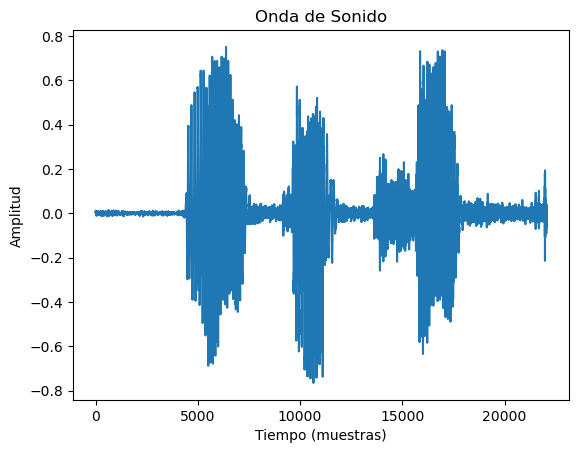

In [14]:
# Vamos a dibujar una de las ondas de audio

import matplotlib.pyplot as plt

# seleccionar una muestra de audio
sample_audio = audio_data[0]

# crear una figura y un eje
fig, ax = plt.subplots()

# plotear la onda de sonido
ax.plot(sample_audio)

# configurar el título y las etiquetas de los ejes
ax.set_title('Onda de Sonido')
ax.set_xlabel('Tiempo (muestras)')
ax.set_ylabel('Amplitud')

# mostrar la figura
plt.show()

In [15]:
# Vamos a escuchar una de las muestras de audio

import IPython.display as ipd

# reproducir el audio

ipd.Audio(sample_audio, rate=sr)